In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [16]:
data = (pd.read_csv("MSFT_f.csv")).dropna()
print(data)


           Date       Close
0    20/10/2021  307.410004
1    21/10/2021  310.760010
2    22/10/2021  309.160004
3    25/10/2021  308.130005
4    26/10/2021  310.109985
..          ...         ...
499  16/10/2023  332.640015
500  17/10/2023  332.059998
501  18/10/2023  330.109985
502  19/10/2023  331.320007
503  20/10/2023  326.670013

[504 rows x 2 columns]


# Step 2

           Date       Close       Log  Volatility  Annualized_Volatility
245  11/10/2022  225.410004 -0.016892         NaN                    NaN
246  12/10/2022  225.750000  0.001507         NaN                    NaN
247  13/10/2022  234.240005  0.036918         NaN                    NaN
248  14/10/2022  228.559998 -0.024548         NaN                    NaN
249  17/10/2022  237.529999  0.038495         NaN                    NaN
250  18/10/2022  238.500000  0.004075         NaN                    NaN
251  19/10/2022  236.479996 -0.008506         NaN                    NaN
252  20/10/2022  236.149994 -0.001396    0.020307               0.322364
253  21/10/2022  242.119995  0.024966    0.020359               0.323195
254  24/10/2022  247.250000  0.020967    0.020405               0.323912
255  25/10/2022  250.660004  0.013697    0.020425               0.324230
256  26/10/2022  231.320007 -0.080295    0.021024               0.333743
257  27/10/2022  226.750000 -0.019954    0.020885  

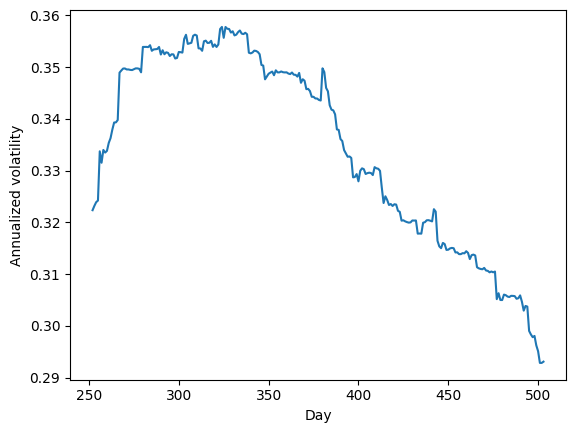

In [17]:
# Calculate daily log returns
data['Log'] = np.log(data['Close'] / data['Close'].shift(1))

# Compute volatility over a window of 252 trading days
data['Volatility'] = data['Log'].rolling(window=252).std()

# Annualize the daily volatility
data['Annualized_Volatility'] = data['Volatility'] * np.sqrt(252)

print(data[245:260])
#print(data)

plt.plot(data['Annualized_Volatility'])
plt.xlabel('Day')
plt.ylabel('Annualized volatility')
plt.show()

From the figure above we see that the volatility goes up the first 100 and then consistently down after that.

# Step 3

In [18]:
from scipy.stats import norm

def d1(S, K, r, sigma, T, t = 0):
    TT = (T - t)/365
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * TT) / (sigma * np.sqrt(TT))
    return d1

def d2(S, K, r, sigma, T, t = 0):
    TT = (T - t)/365
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * TT) / (sigma * np.sqrt(TT))
    return d1 - sigma * np.sqrt(TT)


def black_scholes_call(S, K, r, sigma, T, t = 0):
    """
    Calculate the Black-Scholes price for a European call option.
    
    S: Current stock price
    K: Option strike price
    T: Time until option expiration
    r: Risk-free rate
    sigma: Volatility
    t: starting time
    """
    TT = (T - t)/365
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * TT) / (sigma * np.sqrt(TT))
    d2 = d1 - sigma * np.sqrt(TT)
    return S * norm.cdf(d1) - K * np.exp(-r * TT) * norm.cdf(d2)

def black_scholes_put(S, K, r, sigma, T, t = 0):
    """
    Calculate the Black-Scholes price for a European put option.
    """
    TT = (T - t)/365
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * TT) / (sigma * np.sqrt(TT))
    d2 = d1 - sigma * np.sqrt(TT)
    return K * np.exp(-r * TT) * norm.cdf(-d2) - S * norm.cdf(-d1)

def delta_call(S, K, r, sigma, T, t = 0):
    return norm.cdf(d1(S, K, r, sigma,T, t))

def delta_put(S, K, r, sigma, T, t = 0):
    return norm.cdf(d1(S, K, r, sigma,T, t))-1


call_strike = 240.87
put_strike  = 231.43

# continuously compounded interest
comp_interest = 0.05
volatility = data.loc[data['Date'] == '20/10/2022', 'Annualized_Volatility'].values[0]
print(f"Volatility = {volatility}")

initial_maturity = 365 # days


# date should be 20/10/2021, but that date was removed in step 1
S = data.loc[data['Date'] == '25/10/2021', 'Close'].values[0]  # Initial stock price
r = comp_interest  # continuously compounded interest rate

call_price = black_scholes_call(S, call_strike, r, volatility, initial_maturity)
put_price  = black_scholes_put( S, put_strike,  r, volatility, initial_maturity)

strangle_price = call_price + put_price
print("------------------------------")
print(f"Call Price     = {call_price}")
print(f"Put Price      = {put_price}")
print(f"Strangle Price = {strangle_price}")
print("------------------------------")
# Calculate delta for call and put
d_call = delta_call(S, call_strike, r, volatility, initial_maturity )
d_put  = delta_put( S, call_strike, r, volatility, initial_maturity )

# Bond/bank account holding for call and put
bond_holding_call = call_price - d_call * S # delta is number of initial shares, V = xB+yS (cash)
bond_holding_put  = put_price  - d_put * S

print(f"Call  Option Delta     = {d_call}")
print(f"Put   Option Delta     = {d_put}")
print(f"Total Delta            = {d_call + d_put}")
print(f"Bond  Holding for Call = {bond_holding_call}")
print(f"Bond  Holding for Put  = {bond_holding_put}")
print(f"Bond  Holding total    = {bond_holding_call+bond_holding_put}")

Volatility = 0.32236359220263183
------------------------------
Call Price     = 87.24734247652177
Put Price      = 6.386457140331601
Strangle Price = 93.63379961685337
------------------------------
Call  Option Delta     = 0.8599778619171514
Put   Option Delta     = -0.14002213808284858
Total Delta            = 0.7199557238343028
Bond  Holding for Call = -177.7376404158994
Bond  Holding for Put  = 49.53147924791042
Bond  Holding total    = -128.20616116798897


# Step 4

## 4.1, 4.2 and 4.3

In [19]:
# Parameters
transaction_percentage = 0.002  # 0.2%
rebalance_days = [10, 5, 1]  # Rebalance every nth business day

# Starting point
start_idx = (data['Date'] == '20/10/2022').idxmax()
end_idx = (data['Date'] == '19/10/2023').idxmax()

# Delta hedging over the period with rebalancing
end_value = []
for n_days in rebalance_days:
    # Initialize portfolio on 2022-10-20
    S_start      = data.loc[start_idx, 'Close']
    d_call_start = delta_call(S_start, call_strike, r, volatility, (end_idx - start_idx))
    d_put_start  = delta_put(S_start, put_strike, r, volatility, (end_idx - start_idx))
    shares       = d_call_start + d_put_start
    cash         = strangle_price - shares * S_start * (1 + transaction_percentage)  # Adjusted for transaction cost!
    portfolio_value = [cash + shares * S_start]
    for i in range(start_idx, end_idx, n_days):  # Start the loop from the day after 2022-10-20
        S_t = data.loc[i, 'Close']
        T_t = end_idx - i

        # Compute new deltas
        d_call_t    = delta_call(S_t, call_strike, r, volatility, T_t)
        d_put_t     = delta_put(S_t, put_strike, r, volatility, T_t)
        delta_t     = d_call_t + d_put_t
        shares_diff = delta_t - shares

        # Update cash position and account for transaction costs & interest
        cash *= np.exp(r * n_days / 365)  # Accumulate interest on the bank account
        # when shares_diff is negative, sell shares (get cash), transaction cost when selling or buying
        cash -= shares_diff * S_t + abs(shares_diff) * S_t *transaction_percentage

        # Update shares
        shares += shares_diff
        
        # Record portfolio value for the day
        portfolio = cash + shares * S_t
        portfolio_value.append(portfolio)

    # Value of the replicating portfolio after payoff
    payoff_call = max(0, data.loc[data['Date'] == '20/10/2023', 'Close'].values[0] - call_strike)
    payoff_put = max(0, put_strike - data.loc[data['Date'] == '20/10/2023', 'Close'].values[0])
    payoff = payoff_call + payoff_put
    final_portfolio_value = portfolio - payoff
    end_value.append(final_portfolio_value)
    print(f"Value of the replicating portfolio after payoff on 20/10/2023, hedging every {n_days} days: {final_portfolio_value}")


Value of the replicating portfolio after payoff on 20/10/2023, hedging every 10 days: 34.32563769745417
Value of the replicating portfolio after payoff on 20/10/2023, hedging every 5 days: 48.661238535717786
Value of the replicating portfolio after payoff on 20/10/2023, hedging every 1 days: 41.25866313800594


# 4.4. 
Repeat 4.1 - 4.3 using the volatility calculated on the day of the rebalancing
when estimating the delta


In [20]:
# Parameters
transaction_percentage = 0.002  # 0.2%
rebalance_days = [10, 5, 1]  # Rebalance every nth business day

# Starting point
start_idx = (data['Date'] == '20/10/2022').idxmax()
end_idx = (data['Date'] == '19/10/2023').idxmax()

initial_volatility = volatility
# Delta hedging over the period with rebalancing
end_value_var_volatility = []
for n_days in rebalance_days:
    # Initialize portfolio on 2022-10-20
    S_start      = data.loc[start_idx, 'Close']
    d_call_start = delta_call(S_start, call_strike, r, initial_volatility, (end_idx - start_idx))
    d_put_start  = delta_put(S_start, put_strike, r, initial_volatility, (end_idx - start_idx))
    shares       = d_call_start + d_put_start
    cash         = strangle_price - shares * S_start * (1 + transaction_percentage)  # Adjusted for transaction cost!
    portfolio_value = [cash + shares * S_start]
    for i in range(start_idx, end_idx, n_days):  # Start the loop from the day after 2022-10-20
        S_t = data.loc[i, 'Close']
        T_t = end_idx - i
        
        # changing volatility
        volatility = data.loc[i, 'Annualized_Volatility']

        # Compute new deltas
        d_call_t    = delta_call(S_t, call_strike, r, volatility, T_t)
        d_put_t     = delta_put(S_t, put_strike, r, volatility, T_t)
        delta_t     = d_call_t + d_put_t
        shares_diff = delta_t - shares
        
        # Update cash position and account for transaction costs & interest
        cash *= np.exp(r * n_days / 365)  # Accumulate interest on the bank account
        # when shares_diff is negative, sell shares (get cash), transaction cost when selling or buying
        cash -= shares_diff * S_t + abs(shares_diff) * S_t * transaction_percentage
        # Update shares
        shares += shares_diff
        
        # Record portfolio value for the day
        portfolio = cash + shares * S_t
        portfolio_value.append(portfolio)

    # Value of the replicating portfolio after payoff
    payoff_call = max(0, data.loc[data['Date'] == '20/10/2023', 'Close'].values[0] - call_strike)
    payoff_put = max(0, put_strike - data.loc[data['Date'] == '20/10/2023', 'Close'].values[0])
    payoff = payoff_call + payoff_put
    final_portfolio_value = portfolio - payoff
    end_value_var_volatility.append(final_portfolio_value)
    print(f"Value of the replicating portfolio after payoff on 20/10/2023, hedging every {n_days} days: {final_portfolio_value}")



Value of the replicating portfolio after payoff on 20/10/2023, hedging every 10 days: 33.71336752889158
Value of the replicating portfolio after payoff on 20/10/2023, hedging every 5 days: 48.04709874818133
Value of the replicating portfolio after payoff on 20/10/2023, hedging every 1 days: 40.943256264270246


# Table

In [21]:
#print(end_value)
#print(end_value_var_volatility)

methods = ["Every 10 days", "Every 5 days", "Every 1 day"]

df = pd.DataFrame({
    "Rebalancing Frequency": methods,
    "Rebalanced using Initial Volatility": end_value,
    "Rebalanced using Current Day Volatility": end_value_var_volatility
})


from IPython.display import display, Markdown

display(Markdown("# Replicating Portfolio Final Values"))
display(df)

# Replicating Portfolio Final Values

,Rebalancing Frequency,Rebalanced using Initial Volatility,Rebalanced using Current Day Volatility
0,Every 10 days,34.325638,33.713368
1,Every 5 days,48.661239,48.047099
2,Every 1 day,41.258663,40.943256
